In [17]:
import pycaret
import pandas as pd

In [18]:
train = pd.read_csv('Train.csv')
train = train.drop(columns=['Unnamed: 0'])
train

,DATETIMEDATA,PM25,CO,NO2,TEMP,RH
0,2024-01-01 00:00:00,31.5,0.63,10.00,27,95
1,2024-01-01 01:00:00,35.5,0.61,11.00,27,96
2,2024-01-01 02:00:00,28.3,0.50,5.29,27,93
3,2024-01-01 03:00:00,22.2,0.44,3.00,27,92
4,2024-01-01 04:00:00,27.4,0.43,1.00,26,93
...,...,...,...,...,...,...
898,2024-02-14 11:00:00,32.4,0.53,4.00,33,52
899,2024-02-14 12:00:00,22.1,0.52,4.00,34,49
900,2024-02-14 13:00:00,26.3,0.53,4.00,35,48
901,2024-02-14 14:00:00,21.2,0.52,7.00,36,46


In [19]:
test = pd.read_csv('Test.csv')
test = test.drop(columns=['Unnamed: 0'])
test

,DATETIMEDATA,PM25,CO,NO2,TEMP,RH
0,2024-02-14 16:00:00,26.5,0.55,7.0,35,46
1,2024-02-14 17:00:00,23.7,0.54,10.0,35,47
2,2024-02-14 18:00:00,24.4,0.54,8.0,32,53
3,2024-02-14 19:00:00,25.3,0.59,8.0,32,57
4,2024-02-14 20:00:00,22.6,0.49,7.0,31,60
...,...,...,...,...,...,...
387,2024-03-01 19:00:00,28.7,0.60,12.0,31,65
388,2024-03-01 20:00:00,33.9,0.57,11.0,30,66
389,2024-03-01 21:00:00,30.3,0.53,9.0,30,66
390,2024-03-01 22:00:00,27.5,0.46,6.0,30,66


In [27]:
from pycaret.regression import *
train['DATETIMEDATA'] = pd.to_datetime(train['DATETIMEDATA'])
setup_Model1Day = setup(train, target='TEMP', session_id=103)

,Description,Value
0,Session id,103
1,Target,TEMP
2,Target type,Regression
3,Original data shape,"(903, 6)"
4,Transformed data shape,"(903, 8)"
5,Transformed train set shape,"(632, 8)"
6,Transformed test set shape,"(271, 8)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


In [28]:
best_Model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.5569,0.5297,0.7246,0.9289,0.0230,0.0184,0.1610
gbr,Gradient Boosting Regressor,0.5885,0.5951,0.7667,0.9200,0.0245,0.0196,0.0170
lightgbm,Light Gradient Boosting Machine,0.5982,0.6301,0.7887,0.9154,0.0250,0.0198,0.0750
xgboost,Extreme Gradient Boosting,0.6271,0.6937,0.8286,0.9066,0.0263,0.0208,0.0140
rf,Random Forest Regressor,0.6287,0.6990,0.8323,0.9060,0.0265,0.0209,0.0320
et,Extra Trees Regressor,0.6257,0.7033,0.8334,0.9053,0.0264,0.0207,0.0240
knn,K Neighbors Regressor,0.6550,0.7251,0.8496,0.9025,0.0272,0.0218,0.0100
ada,AdaBoost Regressor,0.7372,0.8553,0.9218,0.8852,0.0295,0.0246,0.0180
lr,Linear Regression,0.7736,0.9631,0.9767,0.8699,0.0320,0.0260,0.0060
lar,Least Angle Regression,0.7736,0.9631,0.9767,0.8699,0.0320,0.0260,0.0070


In [29]:
prediction = predict_model(best_Model)
prediction.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.5085,0.4147,0.6439,0.9384,0.0207,0.0169


,DATETIMEDATA,PM25,CO,NO2,RH,TEMP,prediction_label
839,2024-02-12 00:00:00,30.900000,0.46,0.0,66,28,27.974707
835,2024-02-11 20:00:00,36.799999,0.50,5.0,55,30,31.320630
670,2024-02-04 23:00:00,40.299999,0.63,13.0,75,29,28.442169
546,2024-01-30 19:00:00,19.900000,0.50,7.0,74,29,27.524335
178,2024-01-08 10:00:00,25.400000,0.48,3.0,57,32,32.775840


In [30]:
catboost_model = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4771,0.3902,0.6246,0.9485,0.0202,0.0161
1,0.5863,0.6478,0.8049,0.9096,0.0252,0.0192
2,0.5459,0.5220,0.7225,0.9364,0.0227,0.0179
3,0.7089,0.7343,0.8569,0.9023,0.0271,0.0233
4,0.4879,0.4297,0.6555,0.9395,0.0212,0.0164
5,0.5825,0.5713,0.7558,0.9101,0.0239,0.0194
6,0.5875,0.5401,0.7349,0.9275,0.0238,0.0198
7,0.5207,0.5237,0.7237,0.9384,0.0224,0.0167
8,0.5054,0.4114,0.6414,0.9487,0.0203,0.0166


In [31]:
now = pd.Timestamp.now()
start_date = now.date()
end_date = start_date + pd.DateOffset(days=7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [33]:
predicted_data = pd.DataFrame({'DATETIMEDATA': future_dates})
predicted_data['PM25'] = test['PM25'].mean().round(2)
predicted_data['CO'] = test['CO'].mean().round(2)
predicted_data['NO2'] = test['NO2'].mean().round(2)
predicted_data['RH'] = test['RH'].mean().round(2)

In [34]:
predictions = predict_model(catboost_model, data=predicted_data)
pred = pd.DataFrame(predictions, columns=['DATETIMEDATA', 'prediction_label'])
pred["prediction_label"] = pred["prediction_label"].round(2)
pred

,DATETIMEDATA,prediction_label
0,2024-03-12,30.42
1,2024-03-13,30.33
2,2024-03-14,30.62
3,2024-03-15,30.47
4,2024-03-16,30.55
5,2024-03-17,30.64
6,2024-03-18,30.56
7,2024-03-19,30.57


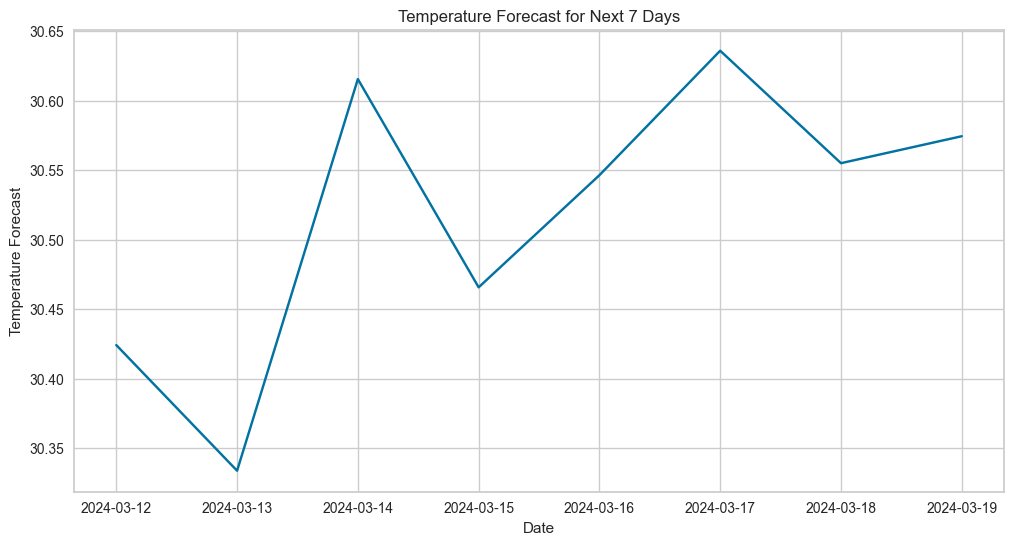

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions['prediction_label'])
plt.xlabel('Date')
plt.ylabel('Temperature Forecast')
plt.title('Temperature Forecast for Next 7 Days')
plt.grid(True)
plt.show()

In [36]:
save_model(catboost_model, 'TEMP_pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['DATETIMEDATA'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['PM25', 'CO', 'NO2', 'RH'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model',
                  <catboost.core.CatBoostRegressor object at 0x00000172CDEB7820>)]),
 'TEMP_pipeline.pkl')